In [6]:
%%time 
import xgboost as xgb
import numpy as np
import pickle
from matplotlib import pyplot as plt
import traceback
from matplotlib.pylab import rcParams
import pandas as pd
import plotly
from sklearn import metrics
from sklearn.model_selection import train_test_split



CPU times: user 48 µs, sys: 0 ns, total: 48 µs
Wall time: 58.2 µs


In [7]:
def load_sexa_data(file):
    data = np.load(file).T
    sig_cutted_data = data[:,(data[1]>0.5) &(data[2]>0.5)]
    bck_cutted_data = data[:,(data[1]<0.5) &(data[2]<0.5)]
    rsd_cutted_data = data[:,~((data[1]>0.5) &(data[2]>0.5))]
    print("Number of parameters: ",len(data))
    print("total candidates: ",len(data[0]))
    print("signal candidates: ",len(sig_cutted_data[0]))
    print("true bckgrd candidates: ",len(bck_cutted_data[0]))
    return data

def permute_data(data,split):
    p = np.random.permutation(len(data.T))
    cutted_data_perm = (data.T[p]).T 


    X = cutted_data_perm[3:28].T
    y =(cutted_data_perm[1] * cutted_data_perm[2]).astype(int)
    y_true_bkg = (cutted_data_perm[1] + cutted_data_perm[2]).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=split, shuffle = False)


    input_data_train = cutted_data_perm.T[:len(y_train)].T
    input_data_test = cutted_data_perm.T[len(y_train):].T
    return X_train, X_test, y_train, y_test,p,y_true_bkg

def load_param_from_study(study_name,verbose):
    with open(study_name, 'rb') as pickle_file:
        study1 = pickle.load(pickle_file)
        print("Best trial until now:")
        print(" Value: ", study1.best_trial.value)
        print(" Params: ")
        if(verbose):
            for key, value in study1.best_trial.params.items():
                print(f"    {key}: {value}")
        return study1.best_trial.params

In [8]:
%%time
#load data
data = (load_sexa_data("MassCutData016.npy"))

#load keys
key_list = np.load("Keys_MassCutData016.npy").tolist()

#do a test train split, which saves the true bkg info as well
X_train, X_test, y_train, y_test,p,y_true_bkg = permute_data(data,0.3)

#load parameters and add the ones not set by optuna
param = load_param_from_study("study_opt_punzi_06.pkl",1)
param["verbosity"] = 0
param["objective"]= "binary:logistic"
param["n_jobs"] = 32
param["eval_metric"] = "logloss"


Number of parameters:  75
total candidates:  8786
signal candidates:  4571
true bckgrd candidates:  3370
Best trial until now:
 Value:  0.20717908639355556
 Params: 
    eval_metric: rmse
    lambda: 1.4675957567755194e-07
    alpha: 0.708494034823813
    eta: 0.03507245488879123
    scale_pos_weight: 0.24452866793789024
    n_estimators: 129
    max_depth: 16
    gamma: 0.00011621135806540938
    grow_policy: lossguide
CPU times: user 25 ms, sys: 11.3 ms, total: 36.3 ms
Wall time: 36.7 ms


In [9]:
#train the classifier
bst_opt = xgb.XGBClassifier(**param)
model_xgb = bst_opt.fit(X_train, y_train,eval_set=[ (X_test, y_test)],  verbose= True)


[0]	validation_0-logloss:0.66513
[1]	validation_0-logloss:0.63955
[2]	validation_0-logloss:0.61489
[3]	validation_0-logloss:0.59171
[4]	validation_0-logloss:0.57010
[5]	validation_0-logloss:0.54975
[6]	validation_0-logloss:0.53079
[7]	validation_0-logloss:0.51322
[8]	validation_0-logloss:0.49670
[9]	validation_0-logloss:0.48117
[10]	validation_0-logloss:0.46623
[11]	validation_0-logloss:0.45183
[12]	validation_0-logloss:0.43821
[13]	validation_0-logloss:0.42517
[14]	validation_0-logloss:0.41285
[15]	validation_0-logloss:0.40085
[16]	validation_0-logloss:0.38955
[17]	validation_0-logloss:0.37868
[18]	validation_0-logloss:0.36786
[19]	validation_0-logloss:0.35780
[20]	validation_0-logloss:0.34854
[21]	validation_0-logloss:0.33944
[22]	validation_0-logloss:0.33094
[23]	validation_0-logloss:0.32254
[24]	validation_0-logloss:0.31459
[25]	validation_0-logloss:0.30682
[26]	validation_0-logloss:0.29912
[27]	validation_0-logloss:0.29175
[28]	validation_0-logloss:0.28486
[29]	validation_0-loglos

In [10]:
y_true_bkg_test = y_true_bkg[len(y_train):]
    
print("total test candidates: ",len(X_test))
print("signal test candidates: ",len(X_test[y_test.astype(bool)]))
print("true bckgrd test candidates: ",len(X_test[~y_true_bkg_test.astype(np.bool)]))


total test candidates:  2636
signal test candidates:  1383
true bckgrd test candidates:  1018


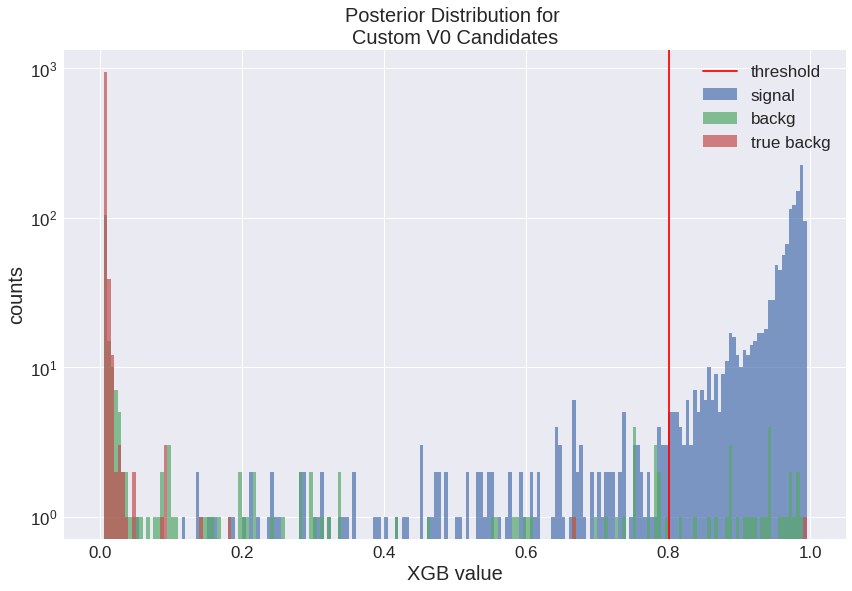

In [11]:
#calc threshold corresponding to efficiency
def calc_threshold(sig_pred,back_pred,efficiency=0.9):
    threshold = np.linspace(0,1, 1000)
    for t in threshold:
        counts = np.sum(sig_pred > t)
        eEff = counts/len(sig_pred)
        if(eEff < efficiency):
            return t
            
    
#predict what candidates in X_test are
preds = bst_opt.predict_proba(X_test)[:,1]

#predictions of signal candidates
sig_pred = preds[y_test.astype(np.bool)]

#predictions of background candidates
back_pred = preds[(~ y_test.astype(np.bool))&(y_true_bkg_test.astype(np.bool))]

#predictions of true background candidates
y_true_bkg_test = y_true_bkg[len(y_train):]
true_back_pred = preds[~ y_true_bkg_test.astype(np.bool)]


efficiency_limit = 0.9
thres = calc_threshold(sig_pred,true_back_pred,efficiency_limit)
 
#plot posterior dist
plt.style.use('seaborn')
fig = plt.figure()
fig.set_size_inches(14, 9)
ax = fig.add_subplot(1, 1, 1)

#plot threshold and posterior dist histogramms
ax.axvline(thres,color = 'r',label = "threshold")
ax.hist(preds[y_test.astype(np.bool)],bins=np.linspace(0,1,201), label= "signal", alpha = 0.7)
ax.hist(back_pred,bins=np.linspace(0,1,201), label= "backg", alpha = 0.7)
ax.hist(true_back_pred,bins=np.linspace(0,1,201), label= "true backg", alpha = 0.7)


#set labels
ax.set_title("Posterior Distribution for \nCustom V0 Candidates", fontsize=20)
ax.set_xlabel('XGB value', fontsize=20)
ax.set_ylabel('counts', fontsize=20)
ax.set_yscale('log')    
ax.tick_params(axis='both', which='major', labelsize=17)
ax.legend(fontsize=17)
#fig.savefig('3_post_dist_custom_V0.png', bbox_inches="tight")

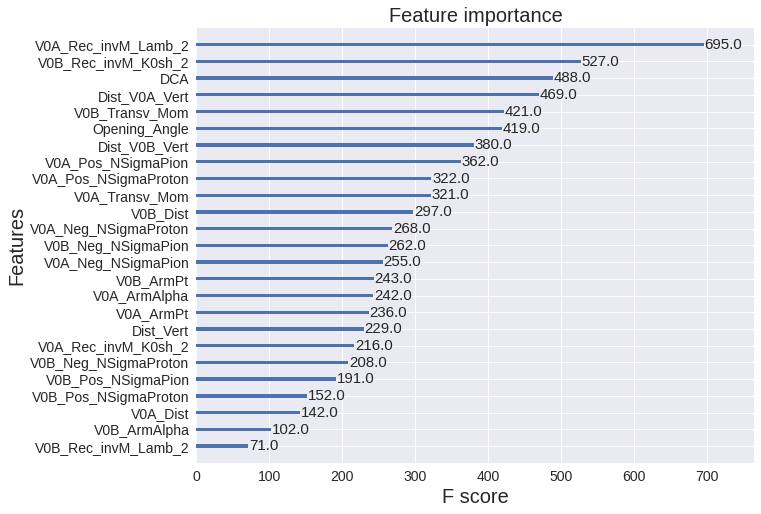

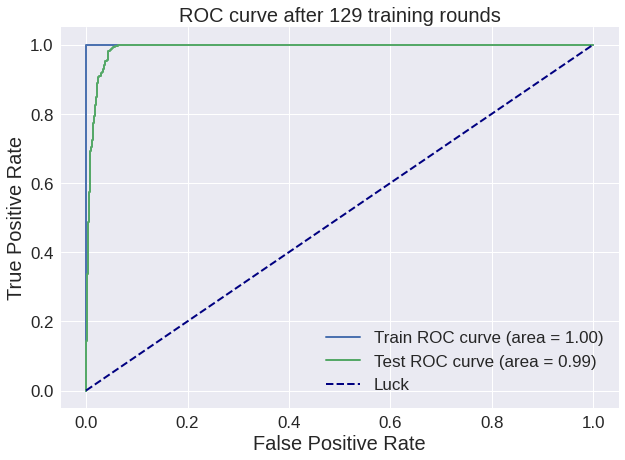

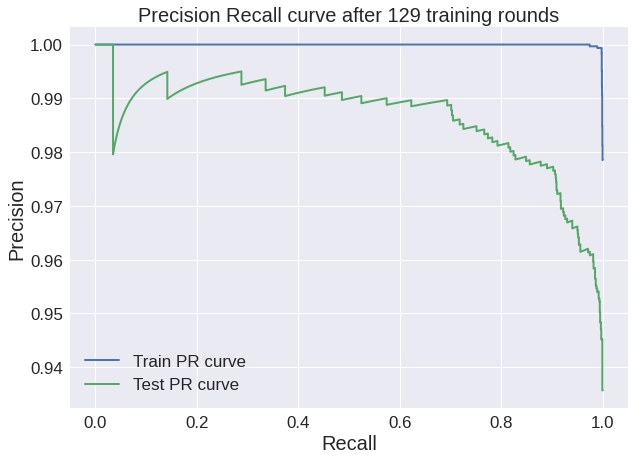

In [12]:
#plot feature importance
#set feature names
bst_opt.get_booster().feature_names = key_list[3:len(X_train[0])+3]

fig, ax = plt.subplots(figsize=(10,8))

params = {'axes.labelsize': 10,
          'axes.titlesize': 20,
            'font.size':15}
ax.xaxis.label.set(fontsize=20)
ax.yaxis.label.set(fontsize=20)
plt.rcParams.update(params)
ax.tick_params(axis='both', which='major', labelsize=14)
#plot importance
xgb.plot_importance(bst_opt, ax=ax)

#fig.savefig('3_Feat_Importance_custom_V0.png', bbox_inches="tight")

#-----------------------------------------------------------
#plot ROC curve
plt.style.use('seaborn')
fig = plt.figure()
fig.set_size_inches(10, 7)
ax = fig.add_subplot(1, 1, 1)
lw = 2

#predict train candidates
check = bst_opt.predict_proba(X_train)
#calculate false positive rate and true positive rate
fpr, tpr, _ = metrics.roc_curve(y_train, check[:,1])
#calc AUC
roc_auc = metrics.auc(fpr, tpr)
#plot them
ax.plot(fpr, tpr,
        lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc)

#repeat for test sample
check = bst_opt.predict_proba(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, check[:,1])
roc_auc = metrics.auc(fpr, tpr)
    
ax.plot(fpr, tpr,
        lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc)
 
    
#plot luck line     
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = "Luck")

#ax.set_yscale('log')    
# set plot parameters
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_title('ROC curve after %d training rounds' % param['n_estimators'], fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.legend(fontsize=17)
#fig.savefig('3_ROC_customV0.png', bbox_inches="tight")


#-------------------------------------------------------------
#plot PR curve
plt.style.use('seaborn')
fig = plt.figure()
fig.set_size_inches(10, 7)
ax = fig.add_subplot(1, 1, 1)
#predict train candidates
check = bst_opt.predict_proba(X_train)
#calc recicion and recall
prec, rec, _ = metrics.precision_recall_curve(y_train, check[:,1])
#plot
ax.plot(rec,prec, 
        lw=lw, label='Train PR curve')

#repeat for test sample
check = bst_opt.predict_proba(X_test)
prec, rec, _ = metrics.precision_recall_curve(y_test, check[:,1])
roc_auc = metrics.auc(fpr, tpr)
    
ax.plot(rec,prec, 
        lw=lw, label='Test PR curve ' )
 

#ax.set_yscale('log')    
# Set Plot parameters
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_title('Precision Recall curve after %d training rounds' % param['n_estimators'], fontsize=20)
ax.set_xlabel('Recall', fontsize=20)
ax.set_ylabel('Precision', fontsize=20)
ax.legend(fontsize=17)

#fig.savefig('3_Prec_Recall.png', bbox_inches="tight")
